# STITCHES Preparing input data

This brief tutorial walks through the preparation of data from raw Pangeo-hosted
NetCDF files to the formatted stitches archive.

The package data is all data that has been processed from raw Pangeo data
 and is generated with package functions (see `stitches.generate_pkg_data()`,
 located at `stitches>stitches>generate_package_data.py`).
 Generating this data from scratch, say with different window sizes or a
 different baseline window,  takes several hours as it processes hundreds  of
 NetCDF files into the `stitches` archive format. It is, however, automated.
 This is considered advanced usage of `stitches` and we highly recommend a
 careful reading of the functions called in `stitches.generate_pkg_data()`
 before making adjustments.

For convenience and rapid cloning  of the github repository, the package data
is also minted on Zenodo and  can be quickly downloaded for using the package:

## Load Package

Start by loading the stitches package (see [installation instructions](https://github.com/jgcri/stitches)
if `stitches` is not yet installed).

In [27]:
import stitches

# Other libraries for this notebook
import pandas as pd
import numpy as np
import os
from importlib import resources
from matplotlib import pyplot as plt

## Internals of `generate_pkg_data()`
The `generate_pkg_data()` function is just a wrapper calling 3 sub functions, with a few
simple arguments. It creates the tas archive, matching archive, and the table of
pangeo files that are automatically downloaded via `stitches.install_package_data()`.
It generates all of the CSV files included in the prebuilt
package and produces temporary files during the process.

The three functions that `generate_pkg_data()` calls, in order are:

1. `stitches.make_tas_archive` held in `stitches>stitches>make_tas_archive.py`.
This  processes CMIP6 data hosted on Pangeo to create an archive of
global average temperature anomaly files for each model, experiment, and
ensemble member. It calculates anomalies based on a specified reference
period, defined by inputs  `anomaly_startYr`  and `anomaly_endYr` that are
directly inherited from `generate_pkg_data()`. The default values for these
arguments are 1995 and 2014, respectively. The csv file for each model is
automatically stored in `"stitches/data/tas-data"`

2. `stitches.make_matching_archive` held in `stitches>stitches>make_matching_archive.py`
operates on the outputs of `make_tas_archive()` in the `"stitches/data/tas-data"`
directory. It smoothes each global average temperature anomaly time using a
running rolling average of input argument `smoothing_window` years, inherited
directly from `generate_pkg_data()` and with a default value of 9 years. It then
'chunks' the time series data into windows of size `chunk_window` (also
inherited, also with a value of 9): for each `chunk_window` sized chunk of
smoothed data, a linear regression is fit and a rate of change (dx) and mean (fx) value
for the regression is used to characterize the window. When argument
`add_staggered` is `False`, windows default to 1850-1858, 1859-1867, etc.
When `add_staggered` is `True`, all possible 9 year windows are created (1850-1858,
1851-1859, 1852-1860, etc). The resulting files are written to
`"stitches/data/matching_archive.csv"` and `"stitches/data/matching_archive_staggered.csv"`.

3. `stitches.make_pangeo_table` held in `stitches>stitches>make_pangeo_table.py`
is the final function called in `generate_pkg_data()`. It has no arguments,
and creates a copy of the Pangeo files metadata that have corresponding entries in the
matching archive. Specifically, it operates directly on the file
`"stitches/data/matching_archive.csv"` output by `stitches.make_matching_archive`.
This function writes the table as `"stitches/data/pangeo_table.csv"` and the
csv file is used in the stitching process to ensure that only relevant Pangeo files
are considered.

*Note*: all files created by `generate_pkg_data()` are prebuilt and can be
downloaded in about 5-10 minutes with a simple call to `stitches.install_package_data()`
after cloning. For more information, please read the package README and see the
quickstart.


The function is called simply:
`stitches.make_tas_archive(anomaly_startYr=1995, anomaly_endYr=2014)`,
but does take several hours to run in full. In lieu of running here,
we repeat some steps from the internal of `stitches.make_tas_archive`
for illustration:

In [4]:
# input arguments:
anomaly_startYr=1995
anomaly_endYr=2014

# Function first gets the pangeo table of contents:
df = stitches.fx_pangeo.fetch_pangeo_table()
print(df.head)

<bound method NDFrame.head of        activity_id       institution_id      source_id       experiment_id  \
0       HighResMIP                 CMCC   CMCC-CM2-HR4  highresSST-present   
1       HighResMIP                 CMCC   CMCC-CM2-HR4  highresSST-present   
2       HighResMIP                 CMCC   CMCC-CM2-HR4  highresSST-present   
3       HighResMIP                 CMCC   CMCC-CM2-HR4  highresSST-present   
4       HighResMIP                 CMCC   CMCC-CM2-HR4  highresSST-present   
...            ...                  ...            ...                 ...   
514813        CMIP  EC-Earth-Consortium  EC-Earth3-Veg          historical   
514814        CMIP  EC-Earth-Consortium  EC-Earth3-Veg          historical   
514815        CMIP  EC-Earth-Consortium  EC-Earth3-Veg          historical   
514816        CMIP  EC-Earth-Consortium  EC-Earth3-Veg          historical   
514817        CMIP  EC-Earth-Consortium  EC-Earth3-Veg          historical   

       member_id table_id variabl

Because `stitches` is designed primarily for operating on ScenarioMIP scenarios,
these are specifically filtered for, and the results are further filtered to only
operate on native grid `gn`, monthly tas files with the `p1` physics setting
of the respective model, as these are what are used to calculate global average
temperature anomalies. The package data does include values for a few
idealized experiments as well, but in practice these are not used.

In [12]:
xps = [
        "historical",
        "1pctCO2",
        "abrupt-4xCO2",
        "abrupt-2xCO2",
        "ssp370",
        "ssp245",
        "ssp119",
        "ssp434",
        "ssp460",
        "ssp126",
        "ssp585",
        "ssp534-over",
    ]
df = df.loc[
    (df["experiment_id"].isin(xps))
    & (df["table_id"] == "Amon")
    & (df["grid_label"] == "gn")
    & (
            df["variable_id"] == "tas"
    )
    & (df["member_id"].str.contains("p1"))
]
print(df.head)
print('===============================================')
print('zstore column only:')
print(df[['zstore']].head)

<bound method NDFrame.head of         activity_id institution_id    source_id experiment_id  member_id  \
32266          CMIP      NASA-GISS  GISS-E2-1-G    historical   r2i1p1f1   
32289          CMIP      NASA-GISS  GISS-E2-1-G    historical   r1i1p1f1   
32456          CMIP      NASA-GISS  GISS-E2-1-G    historical   r3i1p1f1   
32500          CMIP      NASA-GISS  GISS-E2-1-G    historical   r5i1p1f1   
32591          CMIP      NASA-GISS  GISS-E2-1-G    historical   r4i1p1f1   
...             ...            ...          ...           ...        ...   
514683  ScenarioMIP          MIROC       MIROC6        ssp245  r40i1p1f1   
514689  ScenarioMIP          MIROC       MIROC6        ssp245  r41i1p1f1   
514690  ScenarioMIP          MIROC       MIROC6        ssp245  r27i1p1f1   
514692  ScenarioMIP          MIROC       MIROC6        ssp245  r50i1p1f1   
514695  ScenarioMIP          MIROC       MIROC6        ssp245  r29i1p1f1   

       table_id variable_id grid_label  \
32266      Amon

From there, every entry in `df[['zstore']]` is the address of a monthly
tas NetCDF held on pangeo, and the global average temperature time series
is calculated using latitude weights (`(np.cos(np.deg2rad(lat))`)
 using the function`stitches.fx_data.global_mean`.

Then, for each model-experiment-ensemble member in the future
ScenarioMIP experiments (SSP119, SSP126, SSP245, SSP370, SSP460,
SSP434, SSP585, SSP534-over), the corresponding model-ensemble
member `historical` time series is concatenated to create a time series
running from 1850-2100 for each model-experiment-ensemble member.
If a time series is not present for both `historical` and the future experiment
for an ensemble member, it is not included. In-function QC checks include
making sure that the historical period goes back to at least 1855 and that all
data from 2015-2100 is available and complete.

The 1995-2014 (`anomaly_startYr`-`anomaly_endYr`) average is
computed and removed from every value in the time series resulting in
a final file of time series.

To save execution time, we will install the package data from zenodo and
look at an example file (if you have already installed the package data,
feel free to comment this line out:

In [13]:
stitches.install_package_data()

Unzipped: /Users/snyd535/Documents/GitHub/stitches/stitches/data/stitched_CanESM5_tas_ssp245~r1i1p1f1~1.nc
Unzipped: /Users/snyd535/Documents/GitHub/stitches/stitches/data/._stitched_CanESM5_tas_ssp245~r1i1p1f1~1.nc
Unzipped: /Users/snyd535/Documents/GitHub/stitches/stitches/data/matching_archive.csv
Unzipped: /Users/snyd535/Documents/GitHub/stitches/stitches/data/._matching_archive.csv
Unzipped: /Users/snyd535/Documents/GitHub/stitches/stitches/data/pangeo_comparison_table.csv
Unzipped: /Users/snyd535/Documents/GitHub/stitches/stitches/data/._pangeo_comparison_table.csv
Unzipped: /Users/snyd535/Documents/GitHub/stitches/stitches/data/pangeo_table.csv
Unzipped: /Users/snyd535/Documents/GitHub/stitches/stitches/data/._pangeo_table.csv
Unzipped: /Users/snyd535/Documents/GitHub/stitches/stitches/data/stitched_CanESM5_pr_ssp245~r1i1p1f1~1.nc
Unzipped: /Users/snyd535/Documents/GitHub/stitches/stitches/data/._stitched_CanESM5_pr_ssp245~r1i1p1f1~1.nc
Unzipped: /Users/snyd535/Documents/GitHub/

Load one of the files created by `stitches.make_tas_archive` to see the resulting
global average temperature anomaly information for all available experiments for
a particular model:

In [30]:
example = pd.read_csv(
    resources.files("stitches") / "data" / "tas-data" / "CanESM5_tas.csv")
print(resources.files("stitches") / "data" / "tas-data" / "CanESM5_tas.csv")
print(example.head)

/Users/snyd535/Documents/GitHub/stitches/stitches/data/tas-data/CanESM5_tas.csv
<bound method NDFrame.head of       variable experiment  ensemble    model  year     value  \
0          tas    1pctCO2  r1i1p1f1  CanESM5  1850 -1.195729   
1          tas    1pctCO2  r1i1p1f1  CanESM5  1851 -1.255933   
2          tas    1pctCO2  r1i1p1f1  CanESM5  1852 -1.199932   
3          tas    1pctCO2  r1i1p1f1  CanESM5  1853 -1.239345   
4          tas    1pctCO2  r1i1p1f1  CanESM5  1854 -1.294824   
...        ...        ...       ...      ...   ...       ...   
35709      tas     ssp585  r9i1p1f1  CanESM5  2096  6.174021   
35710      tas     ssp585  r9i1p1f1  CanESM5  2097  6.492492   
35711      tas     ssp585  r9i1p1f1  CanESM5  2098  6.436903   
35712      tas     ssp585  r9i1p1f1  CanESM5  2099  6.464588   
35713      tas     ssp585  r9i1p1f1  CanESM5  2100  6.541995   

                                                  zstore  \
0      gs://cmip6/CMIP6/CMIP/CCCma/CanESM5/1pctCO2/r1...   
1

The `zstore` information of the original (non-historical) NetCDF file is included,
along with unit information reflecting the actual argument values used for
`anomaly_startYr` and `anomaly_endYr`.

We can plot the time series for one of these ensemble members in an experiment:

  variable experiment  ensemble    model  year     value  \
0      tas     ssp245  r1i1p1f1  CanESM5  1850 -1.133884   
1      tas     ssp245  r1i1p1f1  CanESM5  1851 -1.389375   
2      tas     ssp245  r1i1p1f1  CanESM5  1852 -1.318175   
3      tas     ssp245  r1i1p1f1  CanESM5  1853 -1.163771   
4      tas     ssp245  r1i1p1f1  CanESM5  1854 -1.302066   

                                  unit  
0  degC change from avg over 1995~2014  
1  degC change from avg over 1995~2014  
2  degC change from avg over 1995~2014  
3  degC change from avg over 1995~2014  
4  degC change from avg over 1995~2014  


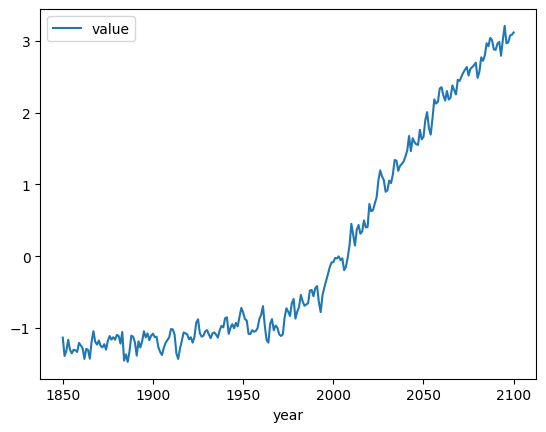

In [28]:
target_data = example.loc[
    (example["model"] == "CanESM5") & (example["experiment"] == "ssp245")
].copy()

target_data = target_data[target_data["ensemble"].isin(["r1i1p1f1"])].copy()

target_data = target_data.drop(columns="zstore").reset_index(drop=True)
print(target_data.head())
target_data.plot(x="year", y="value")
plt.show()
plt.close()

## Details of  `stitches.make_matching_archive`

From the `*-tas.csv` files in `stitches/data/tas-data` created in the previous step,
`stitches.make_matching_archive` smoothes each time series and processes into
chunks that are characterized by the mean value (fx) and rate of change (dx) of
the global average temperature anomaly in that chunk. For the example ensemble
member plotted above, we can see what this data is shaped like:

In [36]:
# Load the package file generated by call:
# stitches.make_matching_archive(
#    smoothing_window = 9, # smooth with a 9 year rolling mean
#    chunk_window = 9,     # break up the smooth time series into 9 year chunks
#    add_staggered = True  # for speed, only look at the 9 year windows beginning 1850, 1851,...
# )

archive = pd.read_csv(
    resources.files("stitches") / "data" / "matching_archive_staggered.csv")


archive[(archive["model"] == "CanESM5") & (archive["experiment"] == "ssp245") &
        archive["ensemble"].isin(["r1i1p1f1"])].sort_values('year')

,model,experiment,variable,ensemble,unit,start_yr,end_yr,year,fx,dx
7685,CanESM5,ssp245,tas,r1i1p1f1,degC change from avg over 1995~2014,1850,1858,1854,-1.289870,-0.003368
31894,CanESM5,ssp245,tas,r1i1p1f1,degC change from avg over 1995~2014,1851,1859,1855,-1.297970,-0.002935
56102,CanESM5,ssp245,tas,r1i1p1f1,degC change from avg over 1995~2014,1852,1860,1856,-1.281846,-0.002675
80309,CanESM5,ssp245,tas,r1i1p1f1,degC change from avg over 1995~2014,1853,1861,1857,-1.277594,-0.003251
104506,CanESM5,ssp245,tas,r1i1p1f1,degC change from avg over 1995~2014,1854,1862,1858,-1.307297,-0.002674
...,...,...,...,...,...,...,...,...,...,...
104532,CanESM5,ssp245,tas,r1i1p1f1,degC change from avg over 1995~2014,2088,2096,2092,2.966451,0.010527
128684,CanESM5,ssp245,tas,r1i1p1f1,degC change from avg over 1995~2014,2089,2097,2093,2.962892,0.011692
152835,CanESM5,ssp245,tas,r1i1p1f1,degC change from avg over 1995~2014,2090,2098,2094,2.984513,0.013538
176970,CanESM5,ssp245,tas,r1i1p1f1,degC change from avg over 1995~2014,2091,2099,2095,3.007958,0.014266


## Details of `stitches.make_pangeo_table`
The final function called by  `generate_pkg_data` is the simplest. From the
file created in the previous step, record the pangeo meta information for all
of the files actually used.

In [37]:
# create and read in the metadata table
stitches.make_pangeo_table()